##### Подключение библиотек

In [988]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [989]:
import warnings
warnings.filterwarnings('ignore')

In [990]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

##### Пути к директориям и файлам

In [991]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'
SAMPLE_SUBMISSION_PATH = '../input/real-estate-price-prediction-moscow/sample_submission.csv'

###### Загрузка данных

Описание датасета

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

In [992]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [993]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [994]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [995]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [996]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 1. EDA

In [997]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Целевая переменная**

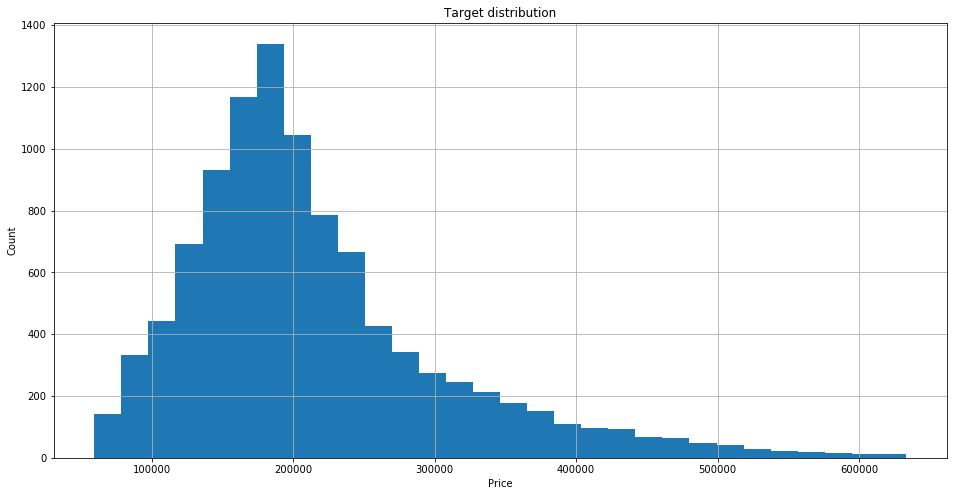

In [998]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [999]:
train_df.select_dtypes(include=['float', 'int']).describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [1000]:
train_df.select_dtypes(include='object').describe()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000,10000
unique,10000,205,2,2,2
top,11809,27,B,B,B
freq,1,851,9903,9725,9175


In [1001]:
print(train_df['DistrictId'].value_counts())
print(train_df['Ecology_2'].value_counts())
print(train_df['Ecology_3'].value_counts())
print(train_df['Shops_2'].value_counts())

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64
B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


**Приведение категориальных переменных к количественных**

In [1002]:
train_df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
train_df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
train_df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

### 2. Обработка выбросов

**Rooms**

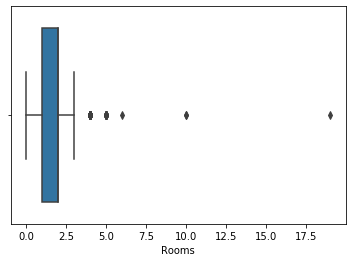

In [1003]:
sns.boxplot(x=train_df['Rooms'])
plt.show()

In [1004]:
new_max_Rooms = np.quantile(train_df['Rooms'], q = 0.995)
new_min_Rooms = np.quantile(train_df['Rooms'], q = 0.005)
print(new_max_Rooms)
print(new_min_Rooms)

4.0
1.0


In [1005]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > new_max_Rooms), 'Rooms_outlier'] = 1

train_df.loc[(train_df['Rooms'] > new_max_Rooms), 'Rooms'] = new_max_Rooms
train_df.loc[(train_df['Rooms'] < new_min_Rooms), 'Rooms'] = new_min_Rooms

**Square**

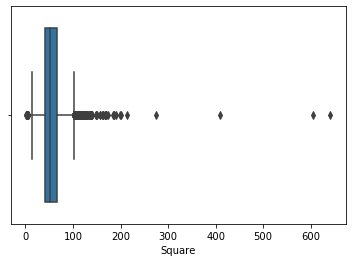

In [1006]:
sns.boxplot(train_df['Square'])

In [1007]:
new_max_Square = np.quantile(train_df['Square'], q = 0.99)
new_min_Square = np.quantile(train_df['Square'], q = 0.01)
print(new_max_Square)
print(new_min_Square)

117.85611482113002
29.719794884038905


In [1008]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] <= new_min_Square) | (train_df['Square'] >= new_max_Square), 'Square_outlier'] = 1

In [1009]:
train_df.loc[train_df['Square_outlier'] == 1].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
count,200.000000,200.000000,150.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,96.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.0
mean,2.040000,88.002178,60.238502,6.365000,7.310000,9.160000,1987.475000,0.109511,0.975000,0.985000,20.740000,4436.095000,10.300000,1496.145833,1.465000,3.87500,0.900000,235750.100871,0.055000,1.0
std,1.181261,84.678717,75.732970,11.260362,6.209403,8.522179,21.278469,0.108960,0.156517,0.121857,17.735987,3956.502384,28.839532,1105.215511,1.649966,5.20334,0.300753,157412.132724,0.228552,0.0
min,1.000000,1.136859,0.873147,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.00000,0.000000,60502.583500,0.000000,1.0
25%,1.000000,27.229666,15.547620,1.000000,3.000000,3.000000,1974.750000,0.019043,1.000000,1.000000,2.000000,629.000000,0.000000,645.000000,0.000000,0.00000,1.000000,124239.111719,0.000000,1.0
50%,1.000000,73.788282,27.666704,3.000000,5.000000,5.000000,1977.000000,0.072158,1.000000,1.000000,22.000000,4429.000000,1.500000,1340.000000,1.000000,2.00000,1.000000,180185.017135,0.000000,1.0
75%,3.000000,132.833421,81.468479,9.250000,9.000000,15.000000,2012.000000,0.194812,1.000000,1.000000,34.000000,6398.000000,6.000000,2300.000000,3.000000,6.00000,1.000000,297112.290422,0.000000,1.0
max,4.000000,641.065193,638.163193,123.000000,28.000000,48.000000,2019.000000,0.460556,1.000000,1.000000,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.00000,1.000000,627525.072788,1.000000,1.0


In [1010]:
train_df.loc[(train_df['Square'] >= new_max_Square), 'Square'] = new_max_Square
train_df.loc[(train_df['Square'] <= new_min_Square), 'Square'] = new_min_Square

**KitchenSquare**

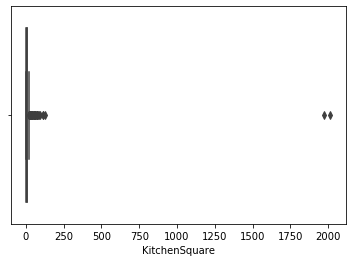

In [1011]:
sns.boxplot(train_df['KitchenSquare'])

In [1012]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [1013]:
new_max_KitchenSquare = np.quantile(train_df['KitchenSquare'], q = 0.99)
new_min_KitchenSquare = np.quantile(train_df['KitchenSquare'], q = 0.01)
print(new_max_KitchenSquare)
print(new_min_KitchenSquare)

train_df.loc[(train_df['KitchenSquare'] > new_max_KitchenSquare), 'KitchenSquare'] = new_max_KitchenSquare
train_df.loc[(train_df['KitchenSquare'] < new_min_KitchenSquare), 'KitchenSquare'] = new_min_KitchenSquare

16.0
0.0


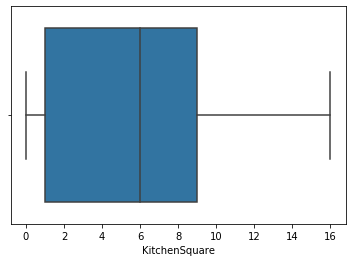

In [1014]:
sns.boxplot(train_df['KitchenSquare'])

**HouseFloor, Floor**

In [1015]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [1016]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [1017]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [1018]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [1019]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1020]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [1021]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [1022]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [1023]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int64

In [1024]:
train_df.loc[X['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков

In [1025]:
train_df.isnull().mean()*100

Id                     0.00
DistrictId             0.00
Rooms                  0.00
Square                 0.00
LifeSquare            21.13
KitchenSquare          0.00
Floor                  0.00
HouseFloor             0.00
HouseYear              0.00
Ecology_1              0.00
Ecology_2              0.00
Ecology_3              0.00
Social_1               0.00
Social_2               0.00
Social_3               0.00
Healthcare_1          47.98
Helthcare_2            0.00
Shops_1                0.00
Shops_2                0.00
Price                  0.00
Rooms_outlier          0.00
Square_outlier         0.00
HouseFloor_outlier     0.00
HouseYear_outlier     99.98
dtype: float64

**LifeSquare**

In [1026]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [1027]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [1028]:
class DataPreprocessing:
    
    def __init__(self):
        "Параметры класса"
        self.medians = None
        
        self.new_max_Rooms = None
        self.new_min_Rooms = None
        
        self.new_max_Square = None
        self.new_min_Square = None
        
        self.new_max_KitchenSquare = None
        self.new_min_KitchenSquare = None
        
    def fit(self, X):
        "Сохранение статистик"
        self.medians = X.median()
        
        self.new_max_Rooms = np.quantile(X['Rooms'], q = 0.995)
        self.new_min_Rooms = np.quantile(X['Rooms'], q = 0.005)
        
        self.new_max_Square = np.quantile(X['Square'], q = 0.99)
        self.new_min_Square = np.quantile(X['Square'], q = 0.01)
        
        self.new_max_KitchenSquare = np.quantile(X['KitchenSquare'], q = 0.99)
        self.new_min_KitchenSquare = np.quantile(X['KitchenSquare'], q = 0.01)
        
    def transform(self, X):
        "Трансформация данных"
        # Приведение типов
        X.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        X.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # Обработка выбросов
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > self.new_max_Rooms), 'Rooms_outlier'] = 1

        X.loc[(X['Rooms'] > self.new_max_Rooms), 'Rooms'] = self.new_max_Rooms
        X.loc[(X['Rooms'] < self.new_min_Rooms), 'Rooms'] = self.new_min_Rooms
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] <= self.new_min_Square) | (X['Square'] >= self.new_max_Square), 'Square_outlier'] = 1
        
        X.loc[(X['Square'] >= self.new_max_Square), 'Square'] = self.new_max_Square
        X.loc[(X['Square'] <= self.new_min_Square), 'Square'] = self.new_min_Square
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] > self.new_max_KitchenSquare), 'KitchenSquare'] = self.new_max_KitchenSquare
        X.loc[(X['KitchenSquare'] < self.new_min_KitchenSquare), 'KitchenSquare'] = self.new_min_KitchenSquare
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
        
        X.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Обработка пропусков
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        condition = (X['LifeSquare'].isna()) \
             & (~X['Square'].isna()) \
             & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                            - X.loc[condition, 'KitchenSquare'] - 3
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков

#### Средняя площадь комнаты в доме (Square_per_Rooms)

In [1029]:
train_df['Square_per_Rooms'] = train_df['LifeSquare'] / train_df['Rooms']

In [1030]:
train_df[['Rooms', 'Square_per_Rooms']].describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.886600,0.806725,1.000000,1.000000,2.000000,2.000000,4.00000
Square_per_Rooms,10000.0,23.344481,27.555811,0.213941,15.821611,19.880918,28.167861,2493.53071


##### Возраст дома (HouseAge)

In [1031]:
current_year = datetime.now().year
train_df['HouseAge'] = current_year - train_df['HouseYear']
train_df['HouseAge'].describe()

count    10000.000000
mean        37.127600
std         18.416347
min          2.000000
25%         21.000000
50%         45.000000
75%         48.000000
max        112.000000
Name: HouseAge, dtype: float64

#### MedPriceByDistrict

In [1032]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [1033]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,Square_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Square_per_Rooms,HouseAge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,0,NaN,1,34.009104,8,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,NaN,0,23.169223,56,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,NaN,0,15.890657,34,244005.272380
3,2352,1,1.0,40.409907,36.409907,1.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,0,NaN,1,36.409907,45,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,NaN,0,19.281258,50,201584.441255


#### MedPriceByFloorYear

In [1034]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [1035]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1.0
1       2.0
2       0.0
3       3.0
4       4.0
       ... 
9995    0.0
9996    3.0
9997    0.0
9998    0.0
9999    2.0
Name: Floor, Length: 10000, dtype: float64

In [1036]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (1, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (1, 3]
9996     (9, 15]
9997      (1, 3]
9998      (1, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(1, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [1037]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Square_per_Rooms,HouseAge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,NaN,1,34.009104,8,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,NaN,0,23.169223,56,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,NaN,0,15.890657,34,244005.272380,4,1
3,2352,1,1.0,40.409907,36.409907,1.0,10,22.0,1977,0.007122,...,0,0,0,NaN,1,36.409907,45,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,NaN,0,19.281258,50,201584.441255,3,5


In [1038]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,374737.658654
1,1,2,324303.812481
2,1,3,395894.847329
3,1,4,274992.472366
4,2,1,467230.539057


In [1039]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Square_per_Rooms,HouseAge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,NaN,1,34.009104,8,213530.788443,6,2,167575.533058
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,NaN,0,23.169223,56,146032.829834,3,3,193357.527619
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,NaN,0,15.890657,34,244005.272380,4,1,205459.068863
3,2352,1,1.0,40.409907,36.409907,1.0,10,22.0,1977,0.007122,...,0,0,NaN,1,36.409907,45,146735.671740,3,4,183494.399043
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,NaN,0,19.281258,50,201584.441255,3,5,173028.982008


In [1040]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
 #       X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
 #       X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
 #       X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        X = self.square_per_rooms(X)
        X = self.house_age(X)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def square_per_rooms(self, X):
        X['Square_per_Rooms'] = X['LifeSquare'] / X['Rooms']
    
        X['1_room'] = 0
        X.loc[(X['Rooms'] == 1), '1_room'] = 1
    
        return X

    def house_age(self, X):
        current_year = datetime.now().year
        X['HouseAge'] = current_year - X['HouseYear']
    
        return X
    

### 5. Отбор признаков

In [1041]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'Square_per_Rooms',
 'HouseAge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [1042]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

In [1043]:
new_feature_names = ['Rooms_outlier', 'Square_outlier', 'HouseFloor_outlier', 
                     'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize', 'new_district', 
                     'IsDistrictLarge', 'floor_cat', 'year_cat', 'MedPriceByDistrict', 
                     'MedPriceByFloorYear', 'Square_per_Rooms', '1_room', 'HouseAge']

target_name = 'Price'

### 6. Разбиение на train и test

In [1044]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [1045]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [1046]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 23), (2500, 23), (5000, 23))

In [1047]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 33), (2500, 33), (5000, 33))

In [1048]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

### 7. Построение модели

#### Обучение

In [1049]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

#### Оценка модели

Train R2:	0.966
Test R2:	0.702


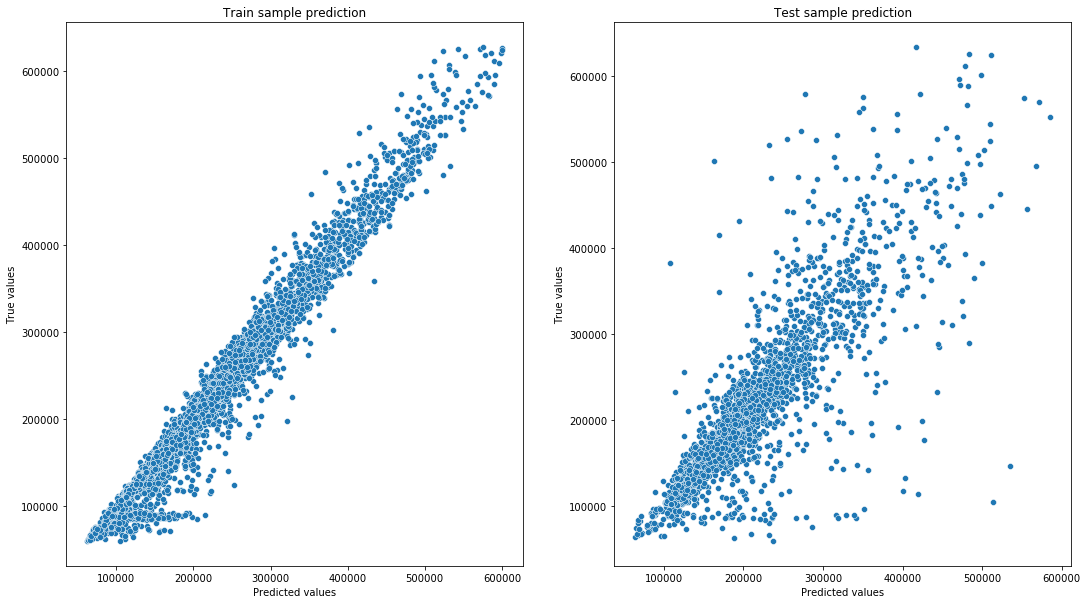

In [1050]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [1051]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75113503, 0.74912101, 0.76408806])

In [1052]:
cv_score.mean()

0.754781364702137

#### Важность признаков

In [1053]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
26,MedPriceByDistrict,6.319967e-01
1,Square,1.058284e-01
28,Square_per_Rooms,3.261345e-02
2,LifeSquare,2.437395e-02
27,MedPriceByFloorYear,2.098477e-02
21,DistrictSize,1.950559e-02
3,KitchenSquare,1.918474e-02
12,Social_3,1.906144e-02
5,HouseFloor,1.776128e-02
7,Ecology_1,1.610367e-02


#### 8. Прогнозирование на тестовом датасете

In [1054]:
test_df.shape

(5000, 31)

In [1055]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,Square_per_Rooms,1_room,HouseAge
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,82.0,0,0,1.0,2.0,170455.930747,188099.807318,19.094182,1,52
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,179.0,0,1,2.0,5.0,130720.196859,179204.334714,42.568133,1,5
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,643.0,0,1,4.0,2.0,166692.403253,175622.388268,23.731839,0,45
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,419.0,0,1,0.0,2.0,173257.957590,181577.988481,11.297942,0,57
4,1.0,53.837056,49.837056,1.0,8,17.0,1977,0.309479,1,1,...,77.0,0,0,2.0,2.0,165143.586826,191867.951499,49.837056,1,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,1,1,...,63.0,0,0,1.0,2.0,185083.534141,188099.807318,15.169972,0,60
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,28.0,0,0,4.0,5.0,419315.944641,197197.404414,31.507155,0,4
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,61.0,0,0,0.0,2.0,154030.205137,181577.988481,19.003259,1,56
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,42.0,0,0,2.0,2.0,177482.263846,191867.951499,20.976257,1,52


In [1056]:
submit = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [1057]:
predictions = rf_model.predict(test_df)
predictions

array([156437.72089456, 121771.15042769, 139137.81593173, ...,
       147713.51266041, 187526.18018006, 267659.72863699])

In [1058]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,156437.720895
1,5925,121771.150428
2,960,139137.815932
3,3848,163800.320310
4,746,180858.028024


In [1059]:
submit.to_csv('rf_submit.csv', index=False)